In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#https://www.kaggle.com/andrewmvd/heart-failure-clinical-data
dataset = pd.read_csv("data/heart_failure_clinical_records_dataset.csv")

## Heart Failure Prediction

In [4]:
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
dataset.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [5]:
dataset.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [4]:
x, y = dataset.iloc[:,:-2], dataset.iloc[:,-1]

### Распределение данных

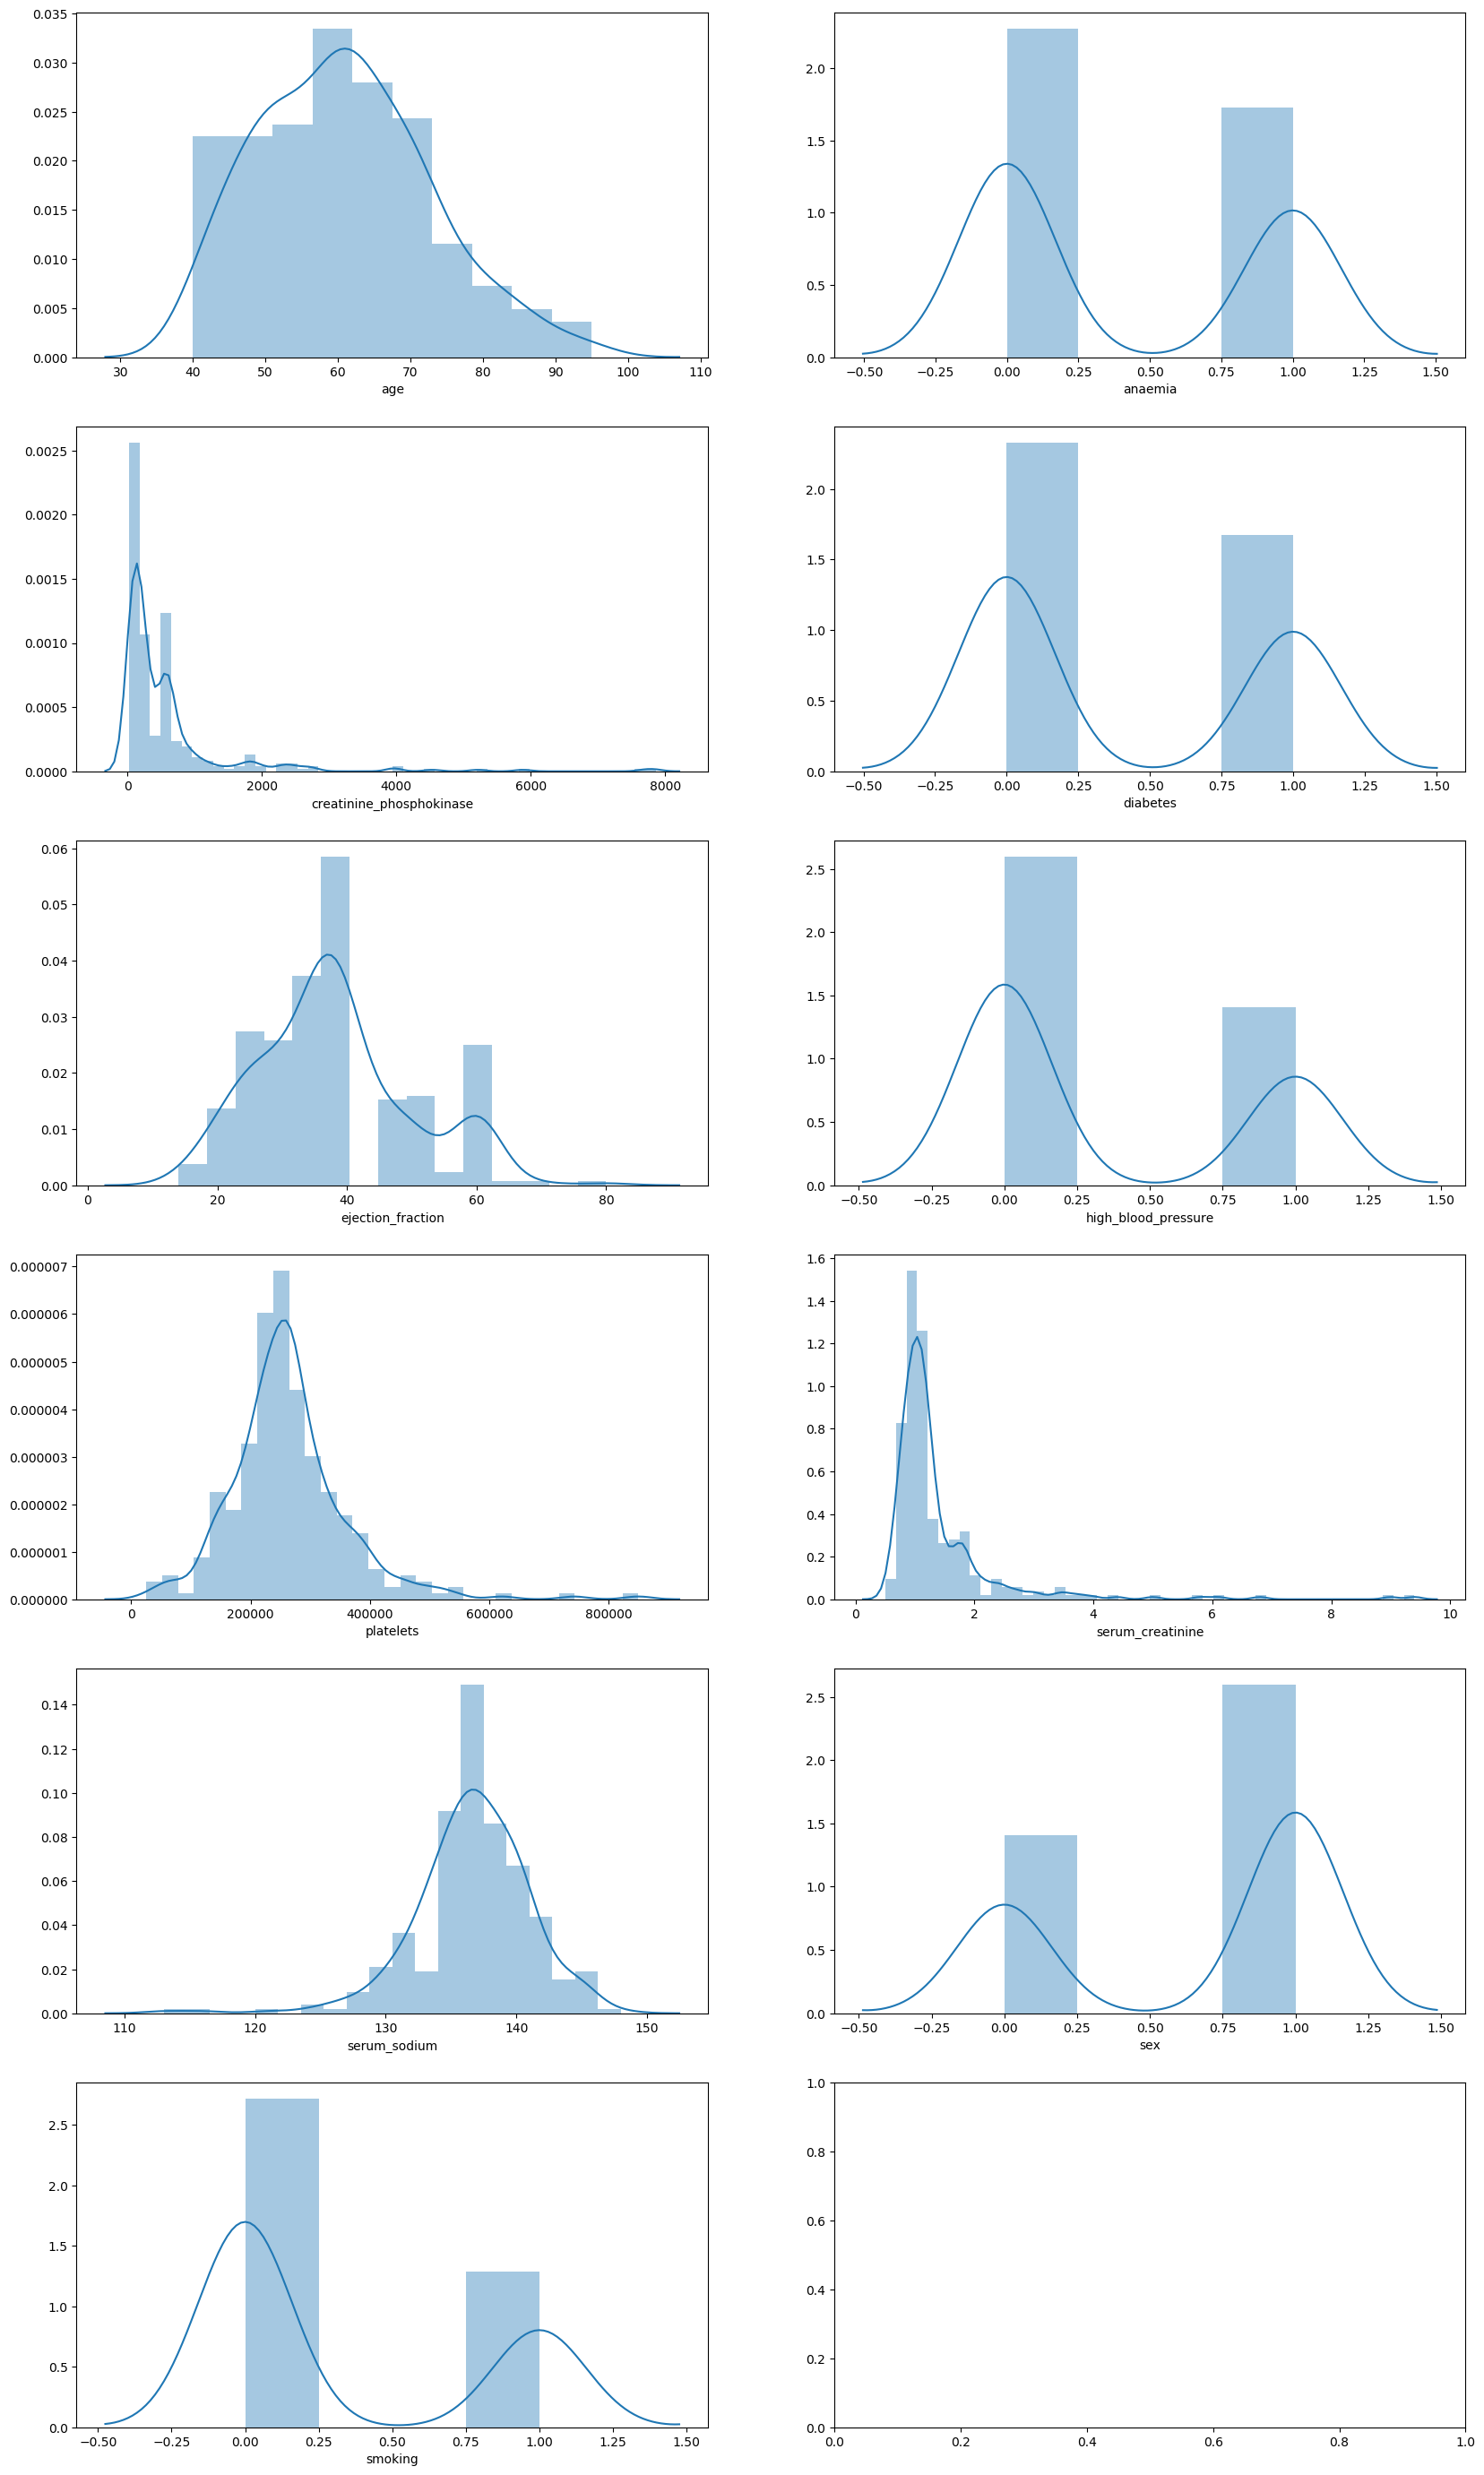

In [19]:
f, axes = plt.subplots(6, 2, figsize=(20, 35))
sns.distplot(x.iloc[:,0], ax=axes[0, 0])
sns.distplot(x.iloc[:,1], ax=axes[0, 1])
sns.distplot(x.iloc[:,2], ax=axes[1, 0])
sns.distplot(x.iloc[:,3], ax=axes[1, 1])
sns.distplot(x.iloc[:,4], ax=axes[2, 0])
sns.distplot(x.iloc[:,5], ax=axes[2, 1])
sns.distplot(x.iloc[:,6], ax=axes[3, 0])
sns.distplot(x.iloc[:,7], ax=axes[3, 1])
sns.distplot(x.iloc[:,8], ax=axes[4, 0])
sns.distplot(x.iloc[:,9], ax=axes[4, 1])
sns.distplot(x.iloc[:,10], ax=axes[5, 0])
#sns.distplot(x.iloc[:,11], ax=axes[5, 1])

In [5]:
feature_names = list(dataset.columns)
feature_names.pop(-1)
feature_names.pop(-1)
feature_names

['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking']

In [6]:
#Restore the rc params from Matplotlib's internal default style
plt.rcdefaults()

## Использование нескольких методов для изучения важности критериев

In [9]:
#Использование F-statictics для определения важности критериев
from sklearn.feature_selection import f_classif
f, pval = f_classif(x, y)
print(pval)

[8.91676295e-06 2.53298815e-01 2.79611246e-01 9.73311827e-01
 2.45289742e-06 1.71149499e-01 3.97194154e-01 2.19019785e-07
 6.88911236e-04 9.40751912e-01 8.27920713e-01]


Text(0.5, 1.0, 'Univariate score ($-Log(p_{value})$)')

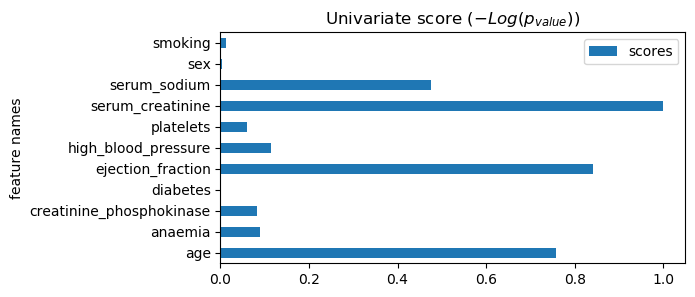

In [17]:
#https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py
scores = -np.log10(pval)
scores /= scores.max()
X_indices = np.arange(x.shape[-1])
df_to_plot = pd.DataFrame({'feature names':feature_names, 'scores':scores})
df_to_plot.plot.barh(x='feature names', y='scores', figsize=(6, 3))
plt.title(r'Univariate score ($-Log(p_{value})$)')

Text(0.5, 1.0, 'RandomForestClassifier feature importances')

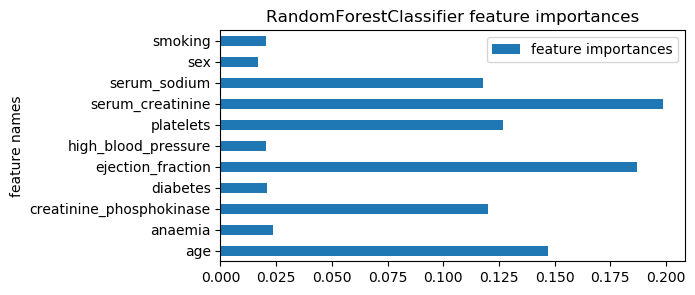

In [18]:
#Использование Random Forest(по книге) для определения важности критериев
#Это лучше для данной цели, чем boosted models, так как последние игнорируют некоторые переменные полностью
forest = RandomForestClassifier()
forest.fit(x, y)
df_to_plot = pd.DataFrame({'feature names':feature_names, 'feature importances':forest.feature_importances_})
df_to_plot.plot.barh(x='feature names', y='feature importances', figsize=(6, 3))
plt.title('RandomForestClassifier feature importances')

Text(0.5, 1.0, 'Permutation feature importance')

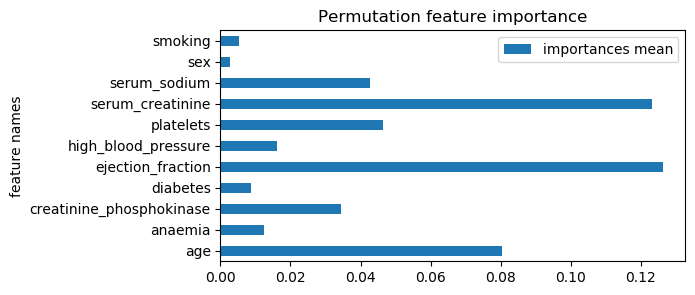

In [22]:
#На сайте sklearn была рекомендация использовать это
from sklearn.inspection import permutation_importance
result = permutation_importance(forest, x, y, n_repeats=10, random_state=0)
df_to_plot = pd.DataFrame({'feature names':feature_names, 'importances mean':result.importances_mean})
df_to_plot.plot.barh(x='feature names', y='importances mean', figsize=(6, 3))
plt.title('Permutation feature importance')

## Обучение и предсказание

In [7]:
scaler = StandardScaler().fit(x)
x_scaled = scaler.transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, random_state=5)

In [8]:
def show_results(estimator, X_train, X_test, y_train, y_test, dataset_scaled, y):
    estimatorScores = cross_val_score(estimator, dataset_scaled, y)
    print("\nРезультат перекрестной проверки: {}".format(estimatorScores))
    print("Средняя правильность перекрестной проверки: {:.3f}".format(estimatorScores.mean()))

    estimator.fit(X_train, y_train)
    estimator_pred = estimator.predict(X_test)
    print('\nMAE: {:.4f}'.format(mean_absolute_error(y_test, estimator_pred)))
    print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, estimator_pred))))   
    #print('R2 {:.4f}'.format(r2_score(y_test, estimator_pred)))
    return estimator

In [28]:
len(dataset.index)

299

### LogisticRegression

LogisticRegression L1

Результат перекрестной проверки: [0.71666667 0.73333333 0.68333333 0.78333333 0.77966102]
Средняя правильность перекрестной проверки: 0.739

MAE: 0.3467
RMSE: 0.5888


Text(0.5, 1.0, 'LogisticRegression L1')

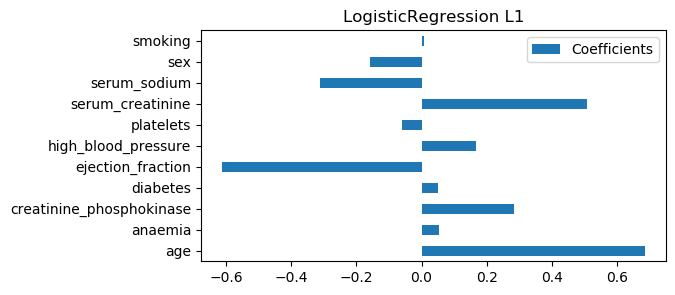

In [36]:
#так как датасет маленький, solver='liblinear'
print("LogisticRegression L1")
log_l1 = show_results(LogisticRegression(penalty="l1", solver='liblinear'), X_train, X_test, y_train, y_test, x_scaled, y)
coefs_l1 = pd.DataFrame(
    log_l1.coef_.reshape(11,1),
    columns=['Coefficients'], index=feature_names
)

coefs_l1.plot(kind='barh', figsize=(6, 3))
plt.title('LogisticRegression L1')

LogisticRegression L2

Результат перекрестной проверки: [0.7        0.73333333 0.7        0.8        0.76271186]
Средняя правильность перекрестной проверки: 0.739

MAE: 0.3333
RMSE: 0.5774


Text(0.5, 1.0, 'LogisticRegression L2')

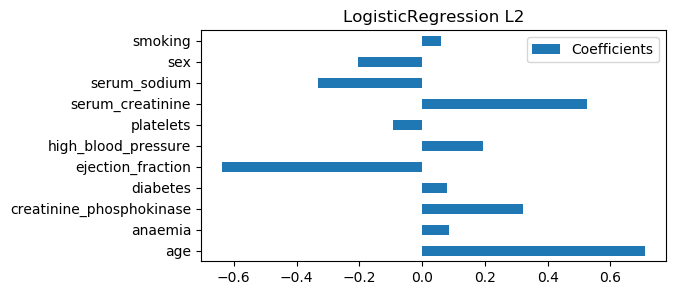

In [39]:
print("LogisticRegression L2")
log_l2 = show_results(LogisticRegression(penalty="l2", solver='liblinear'), X_train, X_test, y_train, y_test, x_scaled, y)
coefs_l2 = pd.DataFrame(
    log_l2.coef_.reshape(11,1),
    columns=['Coefficients'], index=feature_names
)

coefs_l2.plot(kind='barh', figsize=(6, 3))
plt.title('LogisticRegression L2')

### SVC

In [41]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid)
grid_search.fit(X_train, y_train)
print("Правильность на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))

Правильность на тестовом наборе: 0.72
Наилучшие значения параметров: {'C': 10, 'gamma': 0.01}


In [46]:
print("SVC")
svc = show_results(SVC(C = 10, gamma = 0.01), X_train, X_test, y_train, y_test, x_scaled, y)

SVC

Результат перекрестной проверки: [0.75       0.65       0.71666667 0.75       0.72881356]
Средняя правильность перекрестной проверки: 0.719

MAE: 0.2800
RMSE: 0.5292


In [47]:
#Испольнования ансамбля BaggingClassifier
print("BaggingClassifier с SVC")
estimator = BaggingClassifier(base_estimator=SVC(C = 10, gamma = 0.01), n_estimators=10, random_state=0)
svc_bagging = show_results(estimator, X_train, X_test, y_train, y_test, x_scaled, y)

BaggingClassifier с SVC

Результат перекрестной проверки: [0.78333333 0.66666667 0.75       0.76666667 0.77966102]
Средняя правильность перекрестной проверки: 0.749

MAE: 0.3067
RMSE: 0.5538


### GradientBoostingClassifier

In [47]:
param_grid = {'n_estimators': [10, 30, 50, 70, 100], 'loss': ['deviance', 'exponential']}
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid)
grid_search.fit(X_train, y_train)
print("Правильность на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))

Правильность на тестовом наборе: 0.75
Наилучшие значения параметров: {'loss': 'exponential', 'n_estimators': 30}


In [34]:
param_grid = {'init': [ExtraTreesClassifier(), RandomForestClassifier(), None], 'n_estimators': [10, 30, 50, 100]}
grid_search = GridSearchCV(GradientBoostingClassifier(loss = 'exponential'), param_grid)
grid_search.fit(X_train, y_train)
print("Правильность на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))

Правильность на тестовом наборе: 0.73
Наилучшие значения параметров: {'init': ExtraTreesClassifier(), 'n_estimators': 30}


In [48]:
estimator = GradientBoostingClassifier(n_estimators = 30, loss = 'exponential')
grad_boost = show_results(estimator, X_train, X_test, y_train, y_test, x_scaled, y)


Результат перекрестной проверки: [0.65       0.7        0.76666667 0.8        0.74576271]
Средняя правильность перекрестной проверки: 0.732

MAE: 0.2400
RMSE: 0.4899
